IMPORTS

In [2307]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

In [2308]:
df = pd.read_csv('data/Combined-spreadsheet-V8.csv', header=2)
df.head()

,Notes,Patient,Centre,Visit Date,Visit date in relation to BVP,Year of BVP,Date of BVP,Date of birth,Age at BVP (days),Breed,...,Outcome - Ross 3,<80 at first follow up?,<80 AND Visser success,<80 AND Ross 1 success,<80 AND Ross 2 success,<80 AND Ross 3 success,50% reduction?,Important Notes,Unnamed: 92,Unnamed: 93
0,NaN,1.0,1.0,21/07/2022,NaN,NaN,NaN,12/05/2022,NaN,Golden Retriever,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,04/08/2022,NaN,NaN,04/08/2022,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,05/08/2022,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,06/09/2022,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,17/02/2023,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2309]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [2310]:
# forward fill our patient ID
df['Patient'] = df['Patient'].ffill()

In [2311]:
# group by patient and fill columns that have single values with the values
df['Centre'] = df.groupby('Patient')['Centre'].transform('first')
df['Date of BVP'] = df.groupby('Patient')['Date of BVP'].transform('first')
df['Date of birth'] = df.groupby('Patient')['Date of birth'].transform('first')
df['Breed'] = df.groupby('Patient')['Breed'].transform('first')
df['Brachycephalic (Y/N)'] = df.groupby('Patient')['Brachycephalic (Y/N)'].transform('first')
df['Sex'] = df.groupby('Patient')['Sex'].transform('first')
df['PS Type (A/B)'] = df.groupby('Patient')['PS Type (A/B)'].transform('first')
df['Leaflet Thickening (Y/N)'] = df.groupby('Patient')['Leaflet Thickening (Y/N)'].transform('first')
df['Annular Hypoplasia (Y/N)'] = df.groupby('Patient')['Annular Hypoplasia (Y/N)'].transform('first')
df['Fibrotic tissue at annulus (Y/N)'] = df.groupby('Patient')['Fibrotic tissue at annulus (Y/N)'].transform('first')
df['Fibrotic tissue at sinotubular junction (Y/N)'] = df.groupby('Patient')['Fibrotic tissue at sinotubular junction (Y/N)'].transform('first')
df['Post-stenotic dilation (N/Mild/Moderate/Severe)'] = df.groupby('Patient')['Post-stenotic dilation (N/Mild/Moderate/Severe)'].transform('first')
df['Pulmonary Annulus (mm)'] = df.groupby('Patient')['Pulmonary Annulus (mm)'].transform('first')
df['Aortic Annulus (mm)'] = df.groupby('Patient')['Aortic Annulus (mm)'].transform('first')
df['Ao/PV ratio'] = df.groupby('Patient')['Ao/PV ratio'].transform('first')
df['Pulmonary Annulus (angio)'] = df.groupby('Patient')['Pulmonary Annulus (angio)'].transform('first')
df['Balloon Type/Brand'] = df.groupby('Patient')['Balloon Type/Brand'].transform('first')
df['High/Low Pressure Balloon'] = df.groupby('Patient')['High/Low Pressure Balloon'].transform('first')
df['Balloon Width (mm)'] = df.groupby('Patient')['Balloon Width (mm)'].transform('first')
df['Smaller balloons used'] = df.groupby('Patient')['Smaller balloons used'].transform('first')
df['Balloon Length (mm)'] = df.groupby('Patient')['Balloon Length (mm)'].transform('first')
df['Balloon:annulus (angio)'] = df.groupby('Patient')['Balloon:annulus (angio)'].transform('first')
df['Date of death'] = df.groupby('Patient')['Date of death'].transform('first')
df['Date last known alive'] = df.groupby('Patient')['Date last known alive'].transform('first')
df['Onset of clinical signs'] = df.groupby('Patient')['Onset of clinical signs'].transform('first')
df['Comments'] = df.groupby('Patient')['Comments'].transform('first')
df['Important Notes'] = df.groupby('Patient')['Important Notes'].transform('first')

In [2312]:
# Adding some visit number / preop postop fields
df['Visit_Number'] = df.groupby('Patient').cumcount() + 1

def assign_visit_type(visit_num):
    if visit_num == 1:
        return 'Preop_1'
    elif visit_num == 2:
        return 'Preop_2'
    elif visit_num == 3:
        return 'Postop_1'
    elif visit_num == 4:
        return 'Postop_2'
    else:
        return f'Postop_{visit_num - 2}'  # For additional postop visits

df['Visit_Type'] = df['Visit_Number'].apply(assign_visit_type)

In [2313]:
df['Visit Date'] = pd.to_datetime(df['Visit Date'], format='%d/%m/%Y', errors='coerce')
df['Date of BVP'] = pd.to_datetime(df['Date of BVP'], format='%d/%m/%Y', errors='coerce')

# Calculate days from bvp
df['Visit date in relation to BVP'] = (df['Visit Date'] - df['Date of BVP']).dt.days

# Add year col
df['Year of BVP'] = df['Date of BVP'].dt.year

df[['Patient', 'Visit_Number', 'Visit_Type', 'Visit Date', 'Date of BVP', 'Visit date in relation to BVP', 'Year of BVP']].head(10)

,Patient,Visit_Number,Visit_Type,Visit Date,Date of BVP,Visit date in relation to BVP,Year of BVP
0,1.0,1,Preop_1,2022-07-21,2022-08-04,-14.0,2022
1,1.0,2,Preop_2,2022-08-04,2022-08-04,0.0,2022
2,1.0,3,Postop_1,2022-08-05,2022-08-04,1.0,2022
3,1.0,4,Postop_2,2022-09-06,2022-08-04,33.0,2022
4,1.0,5,Postop_3,2023-02-17,2022-08-04,197.0,2022
5,1.0,6,Postop_4,2023-10-06,2022-08-04,428.0,2022
6,2.0,1,Preop_1,2021-09-24,2021-10-22,-28.0,2021
7,2.0,2,Preop_2,2021-10-21,2021-10-22,-1.0,2021
8,2.0,3,Postop_1,2021-10-22,2021-10-22,0.0,2021
9,2.0,4,Postop_2,2021-11-26,2021-10-22,35.0,2021


In [2314]:
df['Date of birth'].isna().sum()

np.int64(0)

In [2315]:
# adding patient age at BVP
df['Date of birth'] = pd.to_datetime(df['Date of birth'], format='%d/%m/%Y', errors='coerce')

df['Age at BVP (days)'] = (df['Date of BVP'] - df['Date of birth']).dt.days

df[['Patient', 'Date of birth', 'Date of BVP', 'Age at BVP (days)']].head(10)

,Patient,Date of birth,Date of BVP,Age at BVP (days)
0,1.0,2022-05-12,2022-08-04,84
1,1.0,2022-05-12,2022-08-04,84
2,1.0,2022-05-12,2022-08-04,84
3,1.0,2022-05-12,2022-08-04,84
4,1.0,2022-05-12,2022-08-04,84
5,1.0,2022-05-12,2022-08-04,84
6,2.0,2021-05-24,2021-10-22,151
7,2.0,2021-05-24,2021-10-22,151
8,2.0,2021-05-24,2021-10-22,151
9,2.0,2021-05-24,2021-10-22,151


In [2316]:
# Atenolol start date - visit date
# first check for instances where there is no corresponding visit date
med_no_visit = df[df['Atenolol start date'].notna() & df['Visit Date'].isna()]
print(f"Number of medication starts without visit dates: {len(med_no_visit)}")
med_no_visit[['Patient', 'Visit_Number', 'Atenolol start date', 'Visit Date']]

Number of medication starts without visit dates: 7


,Patient,Visit_Number,Atenolol start date,Visit Date
496,88.0,2,17/11/2011,NaT
729,131.0,2,17/07/2023,NaT
818,147.0,2,09/04/2008,NaT
823,148.0,2,10/03/2010,NaT
853,154.0,2,19/08/2009,NaT
871,157.0,2,26/06/2014,NaT
927,167.0,2,23/10/2015,NaT


In [2317]:
df['Atenolol start date'] = pd.to_datetime(df['Atenolol start date'], format='%d/%m/%Y', errors='coerce')

# Use current visit date if available, otherwise use BVP date
df['visit_date_atenolol_calc'] = df['Visit Date'].fillna(df['Date of BVP'])

df['Days Atenolol Start to Visit'] = (df['visit_date_atenolol_calc'] - df['Atenolol start date']).dt.days

used_bvp = df[df['Atenolol start date'].notna() & df['Visit Date'].isna() & df['Date of BVP'].notna()]
print(f"Cases using BVP date: {len(used_bvp.groupby('Patient'))}")

no_visit_at_all = df[df['Atenolol start date'].notna() & df['visit_date_atenolol_calc'].isna()]
print(f"Cases with no visit date available: {len(no_visit_at_all)}")

df[['Patient', 'Visit_Number', 'Visit Date', 'Atenolol start date', 'Days Atenolol Start to Visit']].head(10)

Cases using BVP date: 7
Cases with no visit date available: 0


,Patient,Visit_Number,Visit Date,Atenolol start date,Days Atenolol Start to Visit
0,1.0,1,2022-07-21,NaT,NaN
1,1.0,2,2022-08-04,2022-07-21,14.0
2,1.0,3,2022-08-05,NaT,NaN
3,1.0,4,2022-09-06,NaT,NaN
4,1.0,5,2023-02-17,NaT,NaN
5,1.0,6,2023-10-06,NaT,NaN
6,2.0,1,2021-09-24,NaT,NaN
7,2.0,2,2021-10-21,2021-09-24,27.0
8,2.0,3,2021-10-22,NaT,NaN
9,2.0,4,2021-11-26,NaT,NaN


In [2318]:
no_date_by_type = df[df['Visit Date'].isna()]['Visit_Type'].value_counts()

print("Count of missing visit dates by Visit Type:")
print(no_date_by_type)

Count of missing visit dates by Visit Type:
Visit_Type
Preop_1     43
Preop_2     11
Postop_1     6
Name: count, dtype: int64


In [2319]:
df[(df['Visit Date'].isna()) & (df['Visit_Type'] == 'Postop_1')]

,Notes,Patient,Centre,Visit Date,Visit date in relation to BVP,Year of BVP,Date of BVP,Date of birth,Age at BVP (days),Breed,...,<80 AND Visser success,<80 AND Ross 1 success,<80 AND Ross 2 success,<80 AND Ross 3 success,50% reduction?,Important Notes,Visit_Number,Visit_Type,visit_date_atenolol_calc,Days Atenolol Start to Visit
491,NaN,87.0,3.0,NaT,NaN,2012,2012-04-27,2011-10-30,180,Tibetan Terrier,...,NaN,NaN,NaN,NaN,NaN,"Small PDA never closed, never any evidence of ...",3,Postop_1,2012-04-27,NaN
503,NaN,89.0,3.0,NaT,NaN,2011,2011-06-24,2010-10-29,238,Boxer,...,NaN,NaN,NaN,NaN,NaN,Was referred to RVC for possible patch graft b...,3,Postop_1,2011-06-24,NaN
508,NaN,90.0,3.0,NaT,NaN,2011,2011-01-14,2009-08-28,504,Crossbreed,...,NaN,NaN,NaN,NaN,NaN,Very lethargic on atenolol so was discontinued...,3,Postop_1,2011-01-14,NaN
529,NaN,93.0,3.0,NaT,NaN,2010,2010-05-14,2009-10-20,206,Crossbreed,...,NaN,NaN,NaN,NaN,NaN,None,3,Postop_1,2010-05-14,NaN
671,NaN,119.0,3.0,NaT,NaN,2020,2020-12-18,2020-05-31,201,French Bulldog,...,NaN,NaN,NaN,NaN,NaN,None,3,Postop_1,2020-12-18,NaN
697,NaN,124.0,3.0,NaT,NaN,2021,2021-06-25,2019-12-16,557,Labrador,...,NaN,NaN,NaN,NaN,NaN,None,3,Postop_1,2021-06-25,NaN


In [ ]:
# For each patient, create a forward-filled medication start date, but only while the beta blocker column has values
# TODO: more picky with medication?

def calculate_medication_days(group):
    # Create a column to track the "active" start date
    group['Active Atenolol Start'] = None

    current_start = None

    for idx in group.index:
        # Check if patient is on medication
        if pd.notna(group.loc[idx, 'Beta blocker']):
            # If there's a new start date, update current_start
            if pd.notna(group.loc[idx, 'Atenolol start date']):
                current_start = group.loc[idx, 'Atenolol start date']
            # Use the current active start date
            group.loc[idx, 'Active Atenolol Start'] = current_start
        else:
            # Patient is OFF medication, reset
            current_start = None
            group.loc[idx, 'Active Atenolol Start'] = None

    return group

# Apply to each patient
df = df.groupby('Patient', group_keys=False).apply(calculate_medication_days)

# Now calculate days from the active start date
df['Active Atenolol Start'] = pd.to_datetime(df['Active Atenolol Start'])
df['Running Days on Atenolol'] = (df['Visit Date'] - df['Active Atenolol Start']).dt.days

# Check results
df[['Patient', 'Visit_Number', 'Visit Date', 'Atenolol start date', 'Beta blocker', 'Running Days on Atenolol']].head(20)

/var/folders/nc/4mjw7byx2j91c57f4944nl440000gn/T/ipykernel_9643/1744068947.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Patient', group_keys=False).apply(calculate_medication_days)


,Patient,Visit_Number,Visit Date,Atenolol start date,Beta blocker,Running Days on Atenolol
0,1.0,1,2022-07-21,NaT,NaN,NaN
1,1.0,2,2022-08-04,2022-07-21,Atenolol,14.0
2,1.0,3,2022-08-05,NaT,Atenolol,15.0
3,1.0,4,2022-09-06,NaT,Atenolol,47.0
4,1.0,5,2023-02-17,NaT,NaN,NaN
5,1.0,6,2023-10-06,NaT,NaN,NaN
6,2.0,1,2021-09-24,NaT,NaN,NaN
7,2.0,2,2021-10-21,2021-09-24,Atenolol,27.0
8,2.0,3,2021-10-22,NaT,Atenolol,28.0
9,2.0,4,2021-11-26,NaT,Atenolol,63.0


In [2321]:
df[df['Patient'] == 171][['Patient', 'Visit_Number', 'Visit Date', 'Atenolol start date', 'Beta blocker', 'Running Days on Atenolol']]

,Patient,Visit_Number,Visit Date,Atenolol start date,Beta blocker,Running Days on Atenolol
946,171.0,1,2017-03-17,NaT,NaN,NaN
947,171.0,2,2017-04-18,2017-03-17,Atenolol,32.0
948,171.0,3,2017-04-19,NaT,Atenolol,33.0
949,171.0,4,2017-06-02,NaT,Atenolol,77.0
950,171.0,5,2018-06-07,NaT,NaN,NaN
951,171.0,6,2018-07-27,2018-06-07,Atenolol,50.0
952,171.0,7,2018-12-18,NaT,Atenolol,194.0
953,171.0,8,2019-09-11,NaT,Atenolol,461.0


In [2322]:
missing_days = df[df['Beta blocker'].notna() & df['Running Days on Atenolol'].isna()]
print(f"Number of rows with medication but no running days: {len(missing_days)}")

missing_days[['Patient', 'Visit_Number', 'Visit Date', 'Atenolol start date', 'Beta blocker', 'Running Days on Atenolol']]

Number of rows with medication but no running days: 17


,Patient,Visit_Number,Visit Date,Atenolol start date,Beta blocker,Running Days on Atenolol
496,88.0,2,NaT,2011-11-17,Atenolol,NaN
523,92.0,2,2010-07-22,NaT,Atenolol,NaN
524,92.0,3,2010-07-24,NaT,Atenolol,NaN
525,92.0,4,2010-08-24,NaT,Atenolol,NaN
526,92.0,5,2011-01-11,NaT,Atenolol,NaN
533,94.0,2,2009-07-16,NaT,Atenolol,NaN
534,94.0,3,2009-07-18,NaT,Atenolol,NaN
671,119.0,3,NaT,NaT,Atenolol,NaN
729,131.0,2,NaT,2023-07-17,Atenolol,NaN
818,147.0,2,NaT,2008-04-09,Atenolol,NaN


In [2323]:
negative_count = (df['Days Atenolol Start to Visit'] < 0).sum()
print(f"Number of negative values: {negative_count}")

if negative_count > 0:
    negative_cases = df[df['Days Atenolol Start to Visit'] < 0]
    print(negative_cases[['Patient', 'Visit_Number', 'Visit Date', 'Atenolol start date', 'Days Atenolol Start to Visit']])

Number of negative values: 0


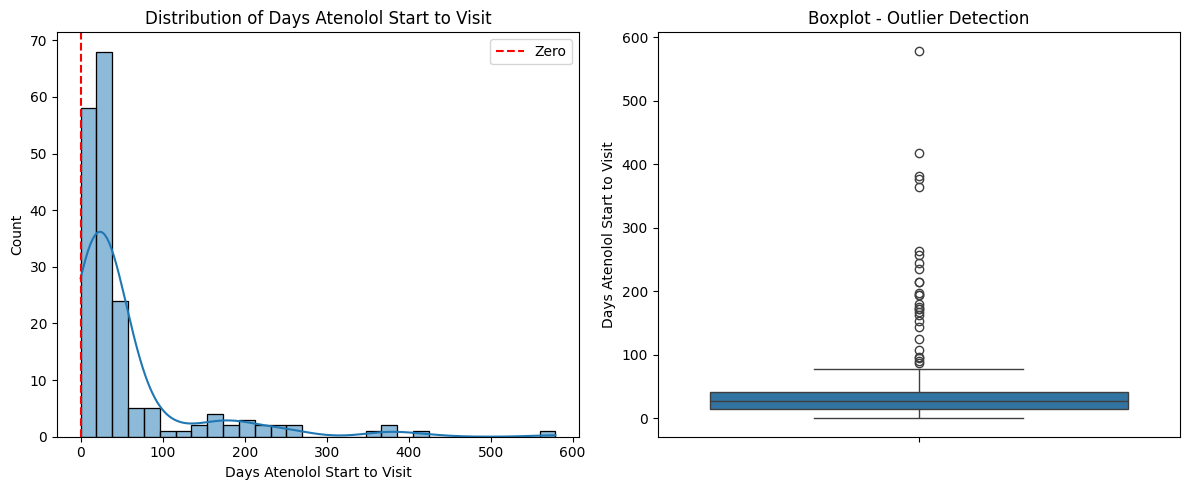

In [2324]:
# Histogram
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Days Atenolol Start to Visit'].dropna(), bins=30, kde=True)
plt.xlabel('Days Atenolol Start to Visit')
plt.title('Distribution of Days Atenolol Start to Visit')
plt.axvline(x=0, color='red', linestyle='--', label='Zero')
plt.legend()

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Days Atenolol Start to Visit'])
plt.ylabel('Days Atenolol Start to Visit')
plt.title('Boxplot - Outlier Detection')

plt.tight_layout()
plt.show()

In [ ]:
outlier_threshold_atenolol = 3000

atenolol_duration_outliers = df[df['Running Days on Atenolol'] > outlier_threshold_atenolol]

atenolol_duration_outliers[['Patient', 'Visit_Number', 'Visit Date', 'Atenolol start date',
               'Running Days on Atenolol']].sort_values('Running Days on Atenolol', ascending=False)

,Patient,Visit_Number,Visit Date,Atenolol start date,Running Days on Atenolol
833,149.0,7,2023-07-06,NaT,3355.0
426,77.0,11,2024-06-03,NaT,3206.0


In [2326]:
df['Beta blocker'].value_counts()

Beta blocker
Atenolol                           676
Sotalol (20 mg BID)                  2
Propranolol 70mg BID                 2
Atenolol, omeprazole, trazodone      1
Sotalol (15 mg BID)                  1
Name: count, dtype: int64

In [2327]:
not_atenolol = df[(df['Beta blocker'].notna()) & (df['Beta blocker'] != 'Atenolol')]

not_atenolol['Patient'].unique()

array([ 20.,  95., 110., 187.])

In [2328]:
df['Date of death'] = pd.to_datetime(df['Date of death'], format='%d/%m/%Y', errors='coerce')

# Days after BVP Death (what about NaN)
df['Days after BVP death'] = (df['Date of death'] - df['Date of BVP']).dt.days

patient_deaths = df[df['Date of death'].notna()]

patient_deaths[['Patient', 'Date of death', 'Date of BVP', 'Days after BVP death']].head(10)

,Patient,Date of death,Date of BVP,Days after BVP death
172,35.0,2022-04-11,2020-10-13,545.0
173,35.0,2022-04-11,2020-10-13,545.0
174,35.0,2022-04-11,2020-10-13,545.0
175,35.0,2022-04-11,2020-10-13,545.0
176,35.0,2022-04-11,2020-10-13,545.0
177,35.0,2022-04-11,2020-10-13,545.0
245,48.0,2022-01-01,2018-01-30,1432.0
246,48.0,2022-01-01,2018-01-30,1432.0
247,48.0,2022-01-01,2018-01-30,1432.0
248,48.0,2022-01-01,2018-01-30,1432.0


In [2329]:
# weird incongruency here. I would expect Date last known alive to = date of death where present. Rest of these dead patients do not have a date last known alive
patient_deaths[patient_deaths['Date last known alive'].notna()][['Patient', 'Date of death', 'Date last known alive']]

,Patient,Date of death,Date last known alive


In [2330]:
print("patients without known last alive date:", df[df['Date last known alive'].isna()]['Patient'].nunique())
print("patients without both known last alive and death dates: ", df[df['Date last known alive'].isna() & df['Date of death'].isna()]['Patient'].nunique())

patients without known last alive date: 15
patients without both known last alive and death dates:  0


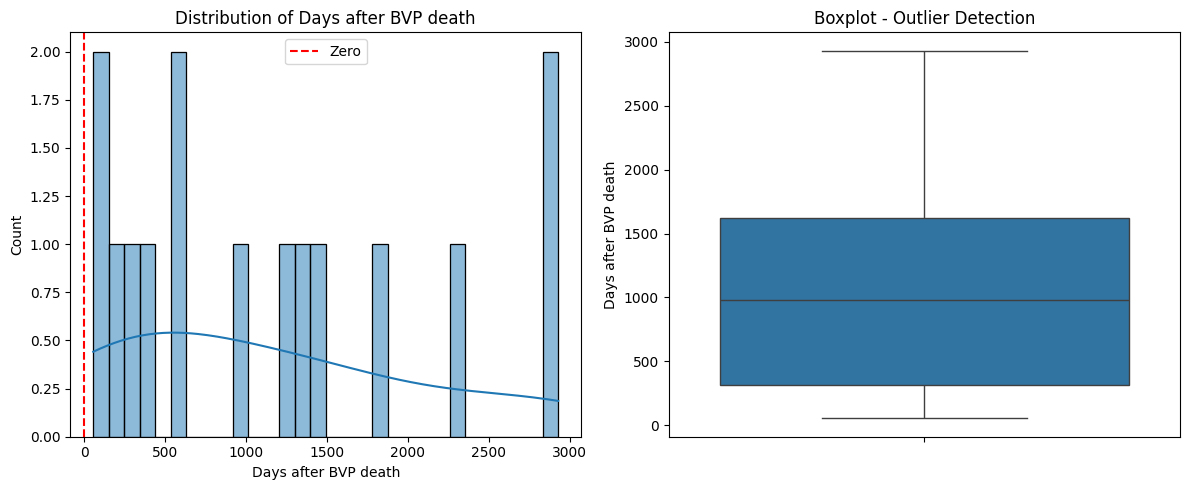

Total deaths: 15

Summary statistics:
count      15.000000
mean     1144.066667
std       979.073795
min        55.000000
25%       316.000000
50%       979.000000
75%      1623.000000
max      2929.000000
Name: Days after BVP death, dtype: float64


In [2331]:
# Get one value per patient (first occurrence)
unique_deaths = df.groupby('Patient')['Days after BVP death'].first().dropna()

# Histogram
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(unique_deaths, bins=30, kde=True)
plt.xlabel('Days after BVP death')
plt.title('Distribution of Days after BVP death')
plt.axvline(x=0, color='red', linestyle='--', label='Zero')
plt.legend()

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y=unique_deaths)
plt.ylabel('Days after BVP death')
plt.title('Boxplot - Outlier Detection')

plt.tight_layout()
plt.show()

print(f"Total deaths: {len(unique_deaths)}")
print(f"\nSummary statistics:")
print(unique_deaths.describe())

In [2332]:
# Days after BVP last known alive (what about NaN) - use last appt - use death date?
df['Date last known alive'] = pd.to_datetime(df['Date last known alive'], format='%d/%m/%Y', errors='coerce')

# First call is date last known alive. If NaN, use date of death
df['Days after BVP last known alive'] = (df['Date last known alive'] - df['Date of BVP']).dt.days

df[['Patient', 'Date last known alive', 'Date of death', 'Days after BVP last known alive']].head(10)

,Patient,Date last known alive,Date of death,Days after BVP last known alive
0,1.0,2023-10-01,NaT,423.0
1,1.0,2023-10-01,NaT,423.0
2,1.0,2023-10-01,NaT,423.0
3,1.0,2023-10-01,NaT,423.0
4,1.0,2023-10-01,NaT,423.0
5,1.0,2023-10-01,NaT,423.0
6,2.0,2022-05-01,NaT,191.0
7,2.0,2022-05-01,NaT,191.0
8,2.0,2022-05-01,NaT,191.0
9,2.0,2022-05-01,NaT,191.0


In [2333]:
df[(df['Date last known alive'].isna()) & (df['Date of death'].isna())]['Patient'].unique()


array([], dtype=float64)

In [2334]:
df[df['Days after BVP last known alive'] <= 0][['Patient', 'Date of BVP', 'Date last known alive', 'Date of death', 'Days after BVP last known alive']]

,Patient,Date of BVP,Date last known alive,Date of death,Days after BVP last known alive


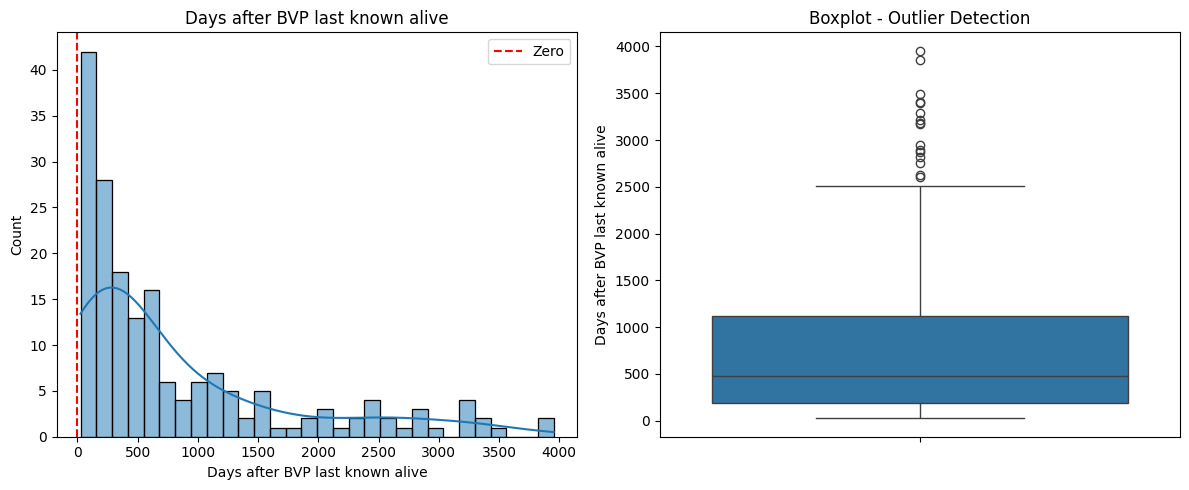

Total days: 182

Summary statistics:
count     182.000000
mean      828.697802
std       943.358226
min        26.000000
25%       189.000000
50%       477.500000
75%      1118.250000
max      3954.000000
Name: Days after BVP last known alive, dtype: float64


In [2335]:
# Get one value per patient (first occurrence)
days_alive = df.groupby('Patient')['Days after BVP last known alive'].first().dropna()

# Histogram
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(days_alive, bins=30, kde=True)
plt.xlabel('Days after BVP last known alive')
plt.title('Days after BVP last known alive')
plt.axvline(x=0, color='red', linestyle='--', label='Zero')
plt.legend()

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y=days_alive)
plt.ylabel('Days after BVP last known alive')
plt.title('Boxplot - Outlier Detection')

plt.tight_layout()
plt.show()

print(f"Total days: {len(days_alive)}")
print(f"\nSummary statistics:")
print(days_alive.describe())

In [2336]:
# restenosis - examine 4th visit PG and Velocities (only 4th visit, or more recent ones if available?)
# first lets look at 4th appointments

fourth_visits = df[df['Visit_Number'] == 4]

print("patients without 4th appointments: ", fourth_visits['Visit Date'].isna().sum())
print("patients without 4th appointment PG: ", fourth_visits['PG'].isna().sum())
print("patients without 4th appointment PV: ", fourth_visits['Pulmonic Velocity'].isna().sum())
print("patients without 4th appointment AOVTI/PVVTI: ", fourth_visits['AOVTI/PVVTI'].isna().sum())

patients without 4th appointments:  0
patients without 4th appointment PG:  0
patients without 4th appointment PV:  0
patients without 4th appointment AOVTI/PVVTI:  43


In [2337]:
VISSER_PG = 33.9
VISSER_VELOCITY = 0.87
ROSS_1_PG = 36.2
ROSS_2_PG = 30.3
ROSS_3_VTI = 0.05

In [ ]:
# First, get the values at the 4th appointment for each patient
fourth_visit_values = df[df['Visit_Number'] == 4].set_index('Patient')[['PG', 'Pulmonic Velocity', 'AOVTI/PVVTI']]
fourth_visit_values.columns = ['PG_restenosis_baseline', 'Velocity_restenosis_baseline', 'AOVTI/PVVTI_baseline']

df = df.join(fourth_visit_values, on='Patient')

df['Restenosis (Y/N) - 33.9 or 0.87 increase (Visser)'] = None

# Only check for visits after the 4th
mask = df['Visit_Number'] > 4
df.loc[mask, 'Restenosis (Y/N) - 33.9 or 0.87 increase (Visser)'] = df.loc[mask].apply(
    lambda row: 'Y' if (
        (row['PG'] - row['PG_restenosis_baseline'] >= VISSER_PG) or
        (row['Pulmonic Velocity'] - row['Velocity_restenosis_baseline'] >= VISSER_VELOCITY)
    ) else 'N',
    axis=1
)

df[['Patient', 'Visit_Number', 'PG', 'Pulmonic Velocity', 'Restenosis (Y/N) - 33.9 or 0.87 increase (Visser)']].head(20)

,Patient,Visit_Number,PG,Pulmonic Velocity,Restenosis (Y/N) - 33.9 or 0.87 increase (Visser)
0,1.0,1,166.41,6.45,None
1,1.0,2,150.31,6.13,None
2,1.0,3,86.86,4.66,None
3,1.0,4,58.37,3.82,None
4,1.0,5,71.91,4.24,N
5,1.0,6,73.96,4.30,N
6,2.0,1,138.77,5.89,None
7,2.0,2,122.32,5.53,None
8,2.0,3,65.61,4.05,None
9,2.0,4,20.25,2.25,None


In [2339]:
# For each patient, determine their restenosis status
def patient_restenosis_status(restenosis_series):
    if (restenosis_series == 'Y').any():
        return 'Y'
    elif (restenosis_series == 'N').any():
        return 'N'
    else:
        return None

# Create the mapping
patient_restenosis = df.groupby('Patient')['Restenosis (Y/N) - 33.9 or 0.87 increase (Visser)'].apply(patient_restenosis_status)

# Map back to all rows
df['Restenosis (Visser)'] = df['Patient'].map(patient_restenosis)

# Check results
df[['Patient', 'Visit_Number', 'Restenosis (Y/N) - 33.9 or 0.87 increase (Visser)', 'Restenosis (Visser)']].head(20)

,Patient,Visit_Number,Restenosis (Y/N) - 33.9 or 0.87 increase (Visser),Restenosis (Visser)
0,1.0,1,None,N
1,1.0,2,None,N
2,1.0,3,None,N
3,1.0,4,None,N
4,1.0,5,N,N
5,1.0,6,N,N
6,2.0,1,None,N
7,2.0,2,None,N
8,2.0,3,None,N
9,2.0,4,None,N


In [2340]:
df['Restenosis (Y/N) - 36.2 increase (Ross 1)'] = None

mask = df['Visit_Number'] > 4
df.loc[mask, 'Restenosis (Y/N) - 36.2 increase (Ross 1)'] = df.loc[mask].apply(
    lambda row: 'Y' if (
        (row['PG'] - row['PG_restenosis_baseline'] >= ROSS_1_PG)
    ) else 'N',
    axis=1
)

patient_restenosis = df.groupby('Patient')['Restenosis (Y/N) - 36.2 increase (Ross 1)'].apply(patient_restenosis_status)

# Map back to all rows
df['Restenosis (Ross 1)'] = df['Patient'].map(patient_restenosis)

# Check results
df[['Patient', 'Visit_Number', 'Restenosis (Y/N) - 36.2 increase (Ross 1)', 'Restenosis (Ross 1)']].head(20)

,Patient,Visit_Number,Restenosis (Y/N) - 36.2 increase (Ross 1),Restenosis (Ross 1)
0,1.0,1,None,N
1,1.0,2,None,N
2,1.0,3,None,N
3,1.0,4,None,N
4,1.0,5,N,N
5,1.0,6,N,N
6,2.0,1,None,N
7,2.0,2,None,N
8,2.0,3,None,N
9,2.0,4,None,N


In [2341]:
df[df['Restenosis (Ross 1)'] == 'Y']['Patient'].nunique()

20

In [2342]:
df['Restenosis (Y/N) - 30.3 increase (Ross 2)'] = None

mask = df['Visit_Number'] > 4
df.loc[mask, 'Restenosis (Y/N) - 30.3 increase (Ross 2)'] = df.loc[mask].apply(
    lambda row: 'Y' if (
        (row['PG'] - row['PG_restenosis_baseline'] >= ROSS_2_PG)
    ) else 'N',
    axis=1
)

patient_restenosis = df.groupby('Patient')['Restenosis (Y/N) - 30.3 increase (Ross 2)'].apply(patient_restenosis_status)

# Map back to all rows
df['Restenosis (Ross 2)'] = df['Patient'].map(patient_restenosis)

# Check results
df[['Patient', 'Visit_Number', 'Restenosis (Y/N) - 30.3 increase (Ross 2)', 'Restenosis (Ross 2)']].head(10)

,Patient,Visit_Number,Restenosis (Y/N) - 30.3 increase (Ross 2),Restenosis (Ross 2)
0,1.0,1,None,N
1,1.0,2,None,N
2,1.0,3,None,N
3,1.0,4,None,N
4,1.0,5,N,N
5,1.0,6,N,N
6,2.0,1,None,N
7,2.0,2,None,N
8,2.0,3,None,N
9,2.0,4,None,N


In [2343]:
df['Restenosis (Y/N) - 0.05 VTI decrease (Ross 3)'] = None

mask = df['Visit_Number'] > 4
df.loc[mask, 'Restenosis (Y/N) - 0.05 VTI decrease (Ross 3)'] = df.loc[mask].apply(
    lambda row: 'Y' if (
        (row['AOVTI/PVVTI_baseline'] - row['AOVTI/PVVTI'] >= ROSS_3_VTI)
    ) else 'N',
    axis=1
)

patient_restenosis = df.groupby('Patient')['Restenosis (Y/N) - 0.05 VTI decrease (Ross 3)'].apply(patient_restenosis_status)

# Map back to all rows
df['Restenosis (Ross 3)'] = df['Patient'].map(patient_restenosis)

# Check results
df[['Patient', 'Visit_Number', 'AOVTI/PVVTI', 'Restenosis (Y/N) - 0.05 VTI decrease (Ross 3)', 'Restenosis (Ross 3)']].head(20)

,Patient,Visit_Number,AOVTI/PVVTI,Restenosis (Y/N) - 0.05 VTI decrease (Ross 3),Restenosis (Ross 3)
0,1.0,1,0.172,None,Y
1,1.0,2,0.127,None,Y
2,1.0,3,NaN,None,Y
3,1.0,4,0.200,None,Y
4,1.0,5,0.138,Y,Y
5,1.0,6,0.175,N,Y
6,2.0,1,0.157,None,N
7,2.0,2,0.129,None,N
8,2.0,3,0.165,None,N
9,2.0,4,0.355,None,N


In [2344]:
df[df['Restenosis (Ross 3)'] == 'Y']['Patient'].nunique()

31

In [2345]:
df[(df['Restenosis (Ross 3)'] == 'Y') | (df['Restenosis (Ross 3)'] == 'N')]['Patient'].nunique()

139

In [2346]:
# Get 2nd appointment values for each patient
second_visit_values = df[df['Visit_Number'] == 2].set_index('Patient')[['PG', 'Pulmonic Velocity', 'AOVTI/PVVTI']]
second_visit_values.columns = ['PG_outcome_ref', 'Velocity_outcome_ref', 'AOVTI/PVVTI_outcome_ref']

# Get 1st appointment values for each patient
first_visit_values = df[df['Visit_Number'] == 1].set_index('Patient')[['PG', 'Pulmonic Velocity', 'AOVTI/PVVTI']]
first_visit_values.columns = ['PG_first', 'Velocity_first', 'AOVTI/PVVTI_first']

# Merge both to the dataframe
df = df.join(second_visit_values, on='Patient')
df = df.join(first_visit_values, on='Patient')

# Fill 2nd visit values with 1st visit values where 2nd is NaN
df['PG_outcome_ref'] = df['PG_outcome_ref'].fillna(df['PG_first'])
df['Velocity_outcome_ref'] = df['Velocity_outcome_ref'].fillna(df['Velocity_first'])
df['AOVTI/PVVTI_outcome_ref'] = df['AOVTI/PVVTI_outcome_ref'].fillna(df['AOVTI/PVVTI_first'])

In [2347]:
patients_no_pg_ref = df[df['PG_outcome_ref'].isna()]['Patient'].nunique()

patients_no_vel_ref = df[df['Velocity_outcome_ref'].isna()]['Patient'].nunique()

patients_no_aovti_ref = df[df['AOVTI/PVVTI_outcome_ref'].isna()]['Patient'].nunique()

print(f"Patients without PG_ref: {patients_no_pg_ref}")
print(f"Patients without Velocity_ref: {patients_no_vel_ref}")
print(f"Patients without AOVTI/PVVTI_ref: {patients_no_aovti_ref}")

Patients without PG_ref: 0
Patients without Velocity_ref: 0
Patients without AOVTI/PVVTI_ref: 24


In [2348]:
ref_outcome_pg_diff = df['PG_outcome_ref'] - df['PG_restenosis_baseline']
ref_outcome_v_diff = df['Velocity_outcome_ref'] - df['Velocity_restenosis_baseline']
ref_outcome_vti_incr = df['AOVTI/PVVTI_baseline'] - df['AOVTI/PVVTI_outcome_ref']

In [2349]:
df['Outcome - Visser'] = ((ref_outcome_pg_diff >= VISSER_PG) | (ref_outcome_v_diff >= VISSER_VELOCITY)).map({True: 'Y', False: 'N'})
df[df['Outcome - Visser'] == 'Y']['Patient'].nunique()

146

In [2350]:
df['Outcome - Ross 1'] = (ref_outcome_pg_diff >= ROSS_1_PG).map({True: 'Y', False: 'N'})
df[df['Outcome - Ross 1'] == 'Y']['Patient'].nunique()

131

In [2351]:
df['Outcome - Ross 2'] = (ref_outcome_pg_diff >= ROSS_2_PG).map({True: 'Y', False: 'N'})
df[df['Outcome - Ross 2'] == 'Y']['Patient'].nunique()

144

In [2352]:
df['Outcome - Ross 3'] = None
mask = ref_outcome_vti_incr.notna()
df.loc[mask, 'Outcome - Ross 3'] = (ref_outcome_vti_incr[mask] >= ROSS_3_VTI).map({True: 'Y', False: 'N'})
df[df['Outcome - Ross 3'] == 'Y']['Patient'].nunique()

96

In [2353]:
df[df['Outcome - Ross 3'].notna()]['Patient'].nunique()

141

In [2354]:
df['<80 at first follow up?'] = None
mask = df['PG_restenosis_baseline'].notna()
df.loc[mask, '<80 at first follow up?'] = (df['PG_restenosis_baseline'][mask] < 80).map({True: 'Y', False: 'N'})
df[df['<80 at first follow up?'] == 'Y']['Patient'].nunique()

158

In [2355]:
df['<80 AND Visser success'] = None
mask = df['Outcome - Visser'].notna()
df.loc[mask, '<80 AND Visser success'] = ((df['<80 at first follow up?'][mask] == 'Y') & (df['Outcome - Visser'][mask] == 'Y')).map({True: 'Y', False: 'N'})
df[df['<80 AND Visser success'] == 'Y']['Patient'].nunique()

128

In [2356]:
df['<80 AND Ross 1 success'] = None
mask = df['Outcome - Ross 1'].notna()
df.loc[mask, '<80 AND Ross 1 success'] = ((df['<80 at first follow up?'][mask] == 'Y') & (df['Outcome - Ross 1'][mask] == 'Y')).map({True: 'Y', False: 'N'})
df[df['<80 AND Ross 1 success'] == 'Y']['Patient'].nunique()

113

In [2357]:
df['<80 AND Ross 2 success'] = None
mask = df['Outcome - Ross 2'].notna()
df.loc[mask, '<80 AND Ross 2 success'] = ((df['<80 at first follow up?'][mask] == 'Y') & (df['Outcome - Ross 2'][mask] == 'Y')).map({True: 'Y', False: 'N'})
df[df['<80 AND Ross 2 success'] == 'Y']['Patient'].nunique()

126

In [2358]:
df['<80 AND Ross 3 success'] = None
mask = df['Outcome - Ross 3'].notna()
df.loc[mask, '<80 AND Ross 3 success'] = ((df['<80 at first follow up?'][mask] == 'Y') & (df['Outcome - Ross 3'][mask] == 'Y')).map({True: 'Y', False: 'N'})
df[df['<80 AND Ross 3 success'] == 'Y']['Patient'].nunique()

89

In [2359]:
df['PG_reduction_percent'] = ((df['PG_outcome_ref'] - df['PG_restenosis_baseline']) / df['PG_outcome_ref']) * 100


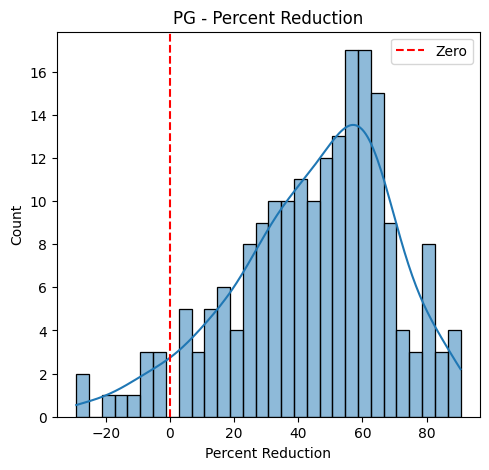

In [2360]:
# Get one value per patient (first occurrence)
pg_reduction = df.groupby('Patient')['PG_reduction_percent'].first().dropna()

# Histogram
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(pg_reduction, bins=30, kde=True)
plt.xlabel('Percent Reduction')
plt.title('PG - Percent Reduction')
plt.axvline(x=0, color='red', linestyle='--', label='Zero')
plt.legend()

In [2361]:
df['50pct reduction?'] = None
mask = df['PG_reduction_percent'].notna()
df.loc[mask, '50pct reduction?'] = (df['PG_reduction_percent'][mask] > 50).map({True: 'Y', False: 'N'})
fifty_pct_y = df[df['50pct reduction?'] == 'Y']['Patient'].nunique()
print(fifty_pct_y, " patients > 50")
print(round(fifty_pct_y/df['Patient'].nunique()*100, 2), " percent of patients")

94  patients > 50
47.72  percent of patients


In [2362]:
# highest post-op PG
post_op_visits = df[df['Visit_Number'] >= 4]

max_visits = df.groupby('Patient')['Visit_Number'].max()

patients_with_followup = max_visits[max_visits > 4].index

# Filter to only patients with >4 visits
post_op_filtered = post_op_visits[post_op_visits['Patient'].isin(patients_with_followup)]

# Calculate highest and lowest PG for each patient (from visits 4+)
highest_pg = post_op_filtered.groupby('Patient')['PG'].max()
lowest_pg = post_op_filtered.groupby('Patient')['PG'].min()

# Map back to dataframe (will be NaN for patients with only 4 visits)
df['Max_PostOp_PG'] = df['Patient'].map(highest_pg)
df['Min_PostOp_PG'] = df['Patient'].map(lowest_pg)

# Check results
df[['Patient', 'Visit_Number', 'PG', 'Max_PostOp_PG', 'Min_PostOp_PG']].head(20)

,Patient,Visit_Number,PG,Max_PostOp_PG,Min_PostOp_PG
0,1.0,1,166.41,73.96,58.37
1,1.0,2,150.31,73.96,58.37
2,1.0,3,86.86,73.96,58.37
3,1.0,4,58.37,73.96,58.37
4,1.0,5,71.91,73.96,58.37
5,1.0,6,73.96,73.96,58.37
6,2.0,1,138.77,20.25,17.31
7,2.0,2,122.32,20.25,17.31
8,2.0,3,65.61,20.25,17.31
9,2.0,4,20.25,20.25,17.31


In [2363]:
df[df['Max_PostOp_PG'].notna()]['Patient'].nunique()

139

In [2364]:
# followups 4+
total_appointments = df.groupby('Patient')['Visit_Number'].max()

follow_ups = total_appointments - 3

df['Number_of_Followups'] = df['Patient'].map(follow_ups)

df[['Patient', 'Visit_Number', 'Number_of_Followups']].drop_duplicates('Patient').head(10)

,Patient,Visit_Number,Number_of_Followups
0,1.0,1,3
6,2.0,1,2
11,3.0,1,2
16,4.0,1,2
21,5.0,1,1
25,6.0,1,2
30,7.0,1,1
34,8.0,1,1
38,9.0,1,1
42,10.0,1,3


In [2365]:
# number of days from BVP to final appt
last_visit_date = df.groupby('Patient')['Visit Date'].max()

# Get the operation date for each patient (should be same for all rows)
op_date = df.groupby('Patient')['Date of BVP'].first()

# Calculate days from last visit to op
days_last_to_op = (last_visit_date - op_date).dt.days

# Map back to dataframe
df['Days_Last_Visit_to_Op'] = df['Patient'].map(days_last_to_op)

df[['Patient', 'Visit_Number', 'Visit Date', 'Date of BVP', 'Days_Last_Visit_to_Op']].drop_duplicates('Patient').head(20)

,Patient,Visit_Number,Visit Date,Date of BVP,Days_Last_Visit_to_Op
0,1.0,1,2022-07-21,2022-08-04,428
6,2.0,1,2021-09-24,2021-10-22,182
11,3.0,1,2020-01-09,2020-02-06,161
16,4.0,1,2020-12-10,2021-01-08,122
21,5.0,1,2022-01-07,2022-01-28,28
25,6.0,1,2021-07-30,2021-08-27,550
30,7.0,1,2021-03-19,2021-04-17,30
34,8.0,1,2021-05-17,2021-05-28,31
38,9.0,1,2022-07-14,2022-08-12,31
42,10.0,1,2023-02-03,2023-02-24,385


In [2366]:
df_unique = df.drop_duplicates(subset='Patient')

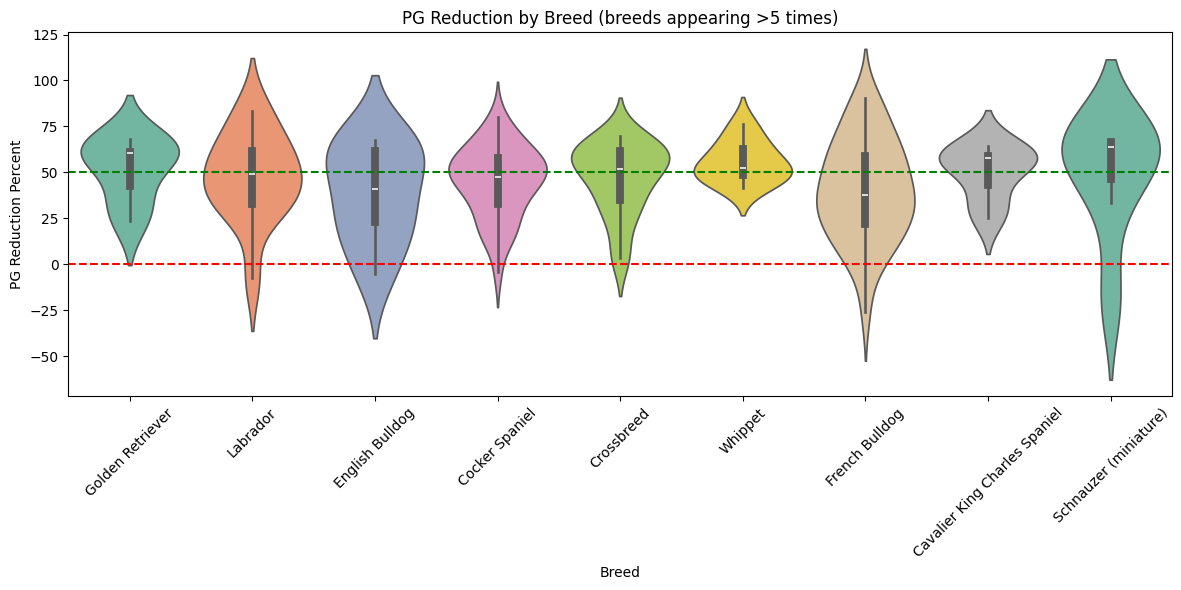

Included breeds and their counts:
Breed
French Bulldog                   37
Cocker Spaniel                   35
Crossbreed                       23
Labrador                         13
English Bulldog                   8
Whippet                           8
Schnauzer (miniature)             7
Cavalier King Charles Spaniel     7
Golden Retriever                  6
Name: count, dtype: int64


In [2367]:
MIN_BREED_COUNT = 5

value_counts = df_unique['Breed'].value_counts()

frequent_values = value_counts[value_counts > MIN_BREED_COUNT].index

df_filtered = df_unique[df_unique['Breed'].isin(frequent_values)]

plt.figure(figsize=(12, 6))
sns.violinplot(data=df_filtered, x='Breed', y='PG_reduction_percent', hue="Breed", palette="Set2")

plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5, label='0% (No change)')
plt.axhline(y=50, color='green', linestyle='--', linewidth=1.5, label='50% reduction')

plt.xlabel('Breed')
plt.ylabel('PG Reduction Percent')
plt.title(f'PG Reduction by Breed (breeds appearing >{MIN_BREED_COUNT} times)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show counts for reference
print("Included breeds and their counts:")
print(value_counts[value_counts > MIN_BREED_COUNT].sort_values(ascending=False))

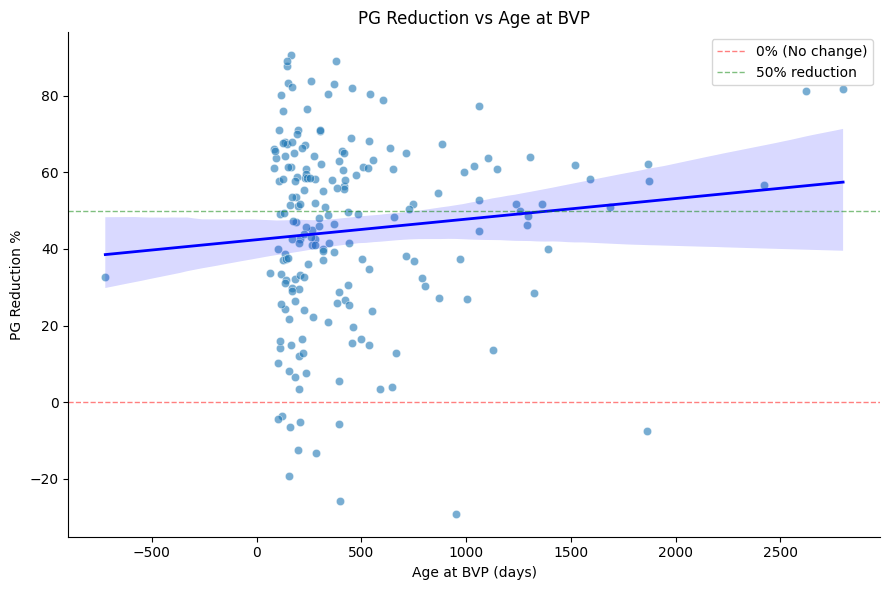

In [ ]:
g = sns.relplot(data=df_unique, x='Age at BVP (days)', y='PG_reduction_percent',
                kind='scatter', alpha=0.6, height=6, aspect=1.5)

# Add regression line
ax = g.axes[0, 0]
sns.regplot(data=df_unique.dropna(subset=['Age at BVP (days)', 'PG_reduction_percent']),
            x='Age at BVP (days)', y='PG_reduction_percent',
            ax=ax, scatter=False, color='blue', line_kws={'linewidth': 2})

# Add reference lines
ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='0% (No change)')
ax.axhline(y=50, color='green', linestyle='--', linewidth=1, alpha=0.5, label='50% reduction')

g.set_axis_labels('Age at BVP (days)', 'PG Reduction %')
plt.title('PG Reduction vs Age at BVP')
plt.legend()
plt.tight_layout()
plt.show()

In [2370]:
negative_age = df_unique[df_unique['Age at BVP (days)'] < 0]

print(f"Number of patients with negative age at BVP: {len(negative_age)}")

negative_age[['Patient', 'Age at BVP (days)', 'Date of birth', 'Date of BVP']]

Number of patients with negative age at BVP: 1


,Patient,Age at BVP (days),Date of birth,Date of BVP
722,130.0,-722,2023-04-13,2021-04-21


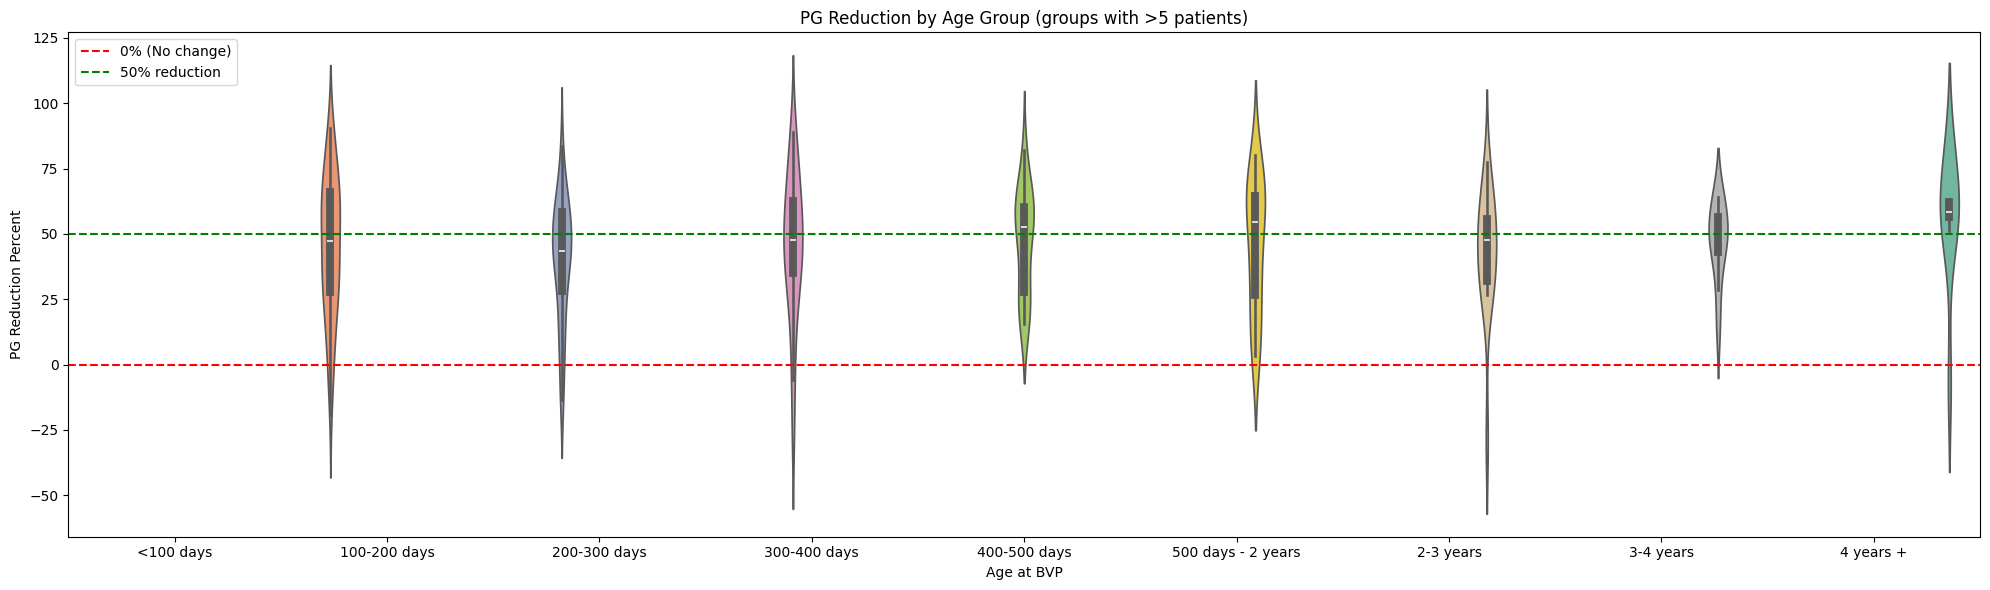

Age group counts:
Age_Group
<100 days              5
100-200 days          55
200-300 days          40
300-400 days          24
400-500 days          18
500 days - 2 years    18
2-3 years             16
3-4 years             11
4 years +              9
Name: count, dtype: int64


In [2371]:
df_age_bin = df.drop_duplicates(subset='Patient').copy()


bins = [0, 100, 200, 300, 400, 500, 730, 1095, 1460, 20000]
labels = ['<100 days', '100-200 days', '200-300 days', '300-400 days', '400-500 days', '500 days - 2 years', '2-3 years', '3-4 years', '4 years +']

df_age_bin['Age_Group'] = pd.cut(df_age_bin['Age at BVP (days)'], bins=bins, labels=labels, right=False)

# Count occurrences of each age group
age_counts = df_age_bin['Age_Group'].value_counts()

# Set threshold
MIN_COUNT = 5  # Adjust as needed

# Get age groups that appear more than x times
frequent_ages = age_counts[age_counts > MIN_COUNT].index

# Filter dataframe
df_filtered = df_age_bin[df_age_bin['Age_Group'].isin(frequent_ages)]

# Create violin plot
plt.figure(figsize=(20, 6))
sns.violinplot(data=df_filtered, x='Age_Group', y='PG_reduction_percent', hue='Age_Group', order=labels, palette='Set2')

# Add reference lines
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5, label='0% (No change)')
plt.axhline(y=50, color='green', linestyle='--', linewidth=1.5, label='50% reduction')

plt.xlabel('Age at BVP')
plt.ylabel('PG Reduction Percent')
plt.title(f'PG Reduction by Age Group (groups with >{MIN_COUNT} patients)')
plt.legend()
plt.tight_layout()
plt.show()

# Show counts
print("Age group counts:")
print(age_counts.sort_index())

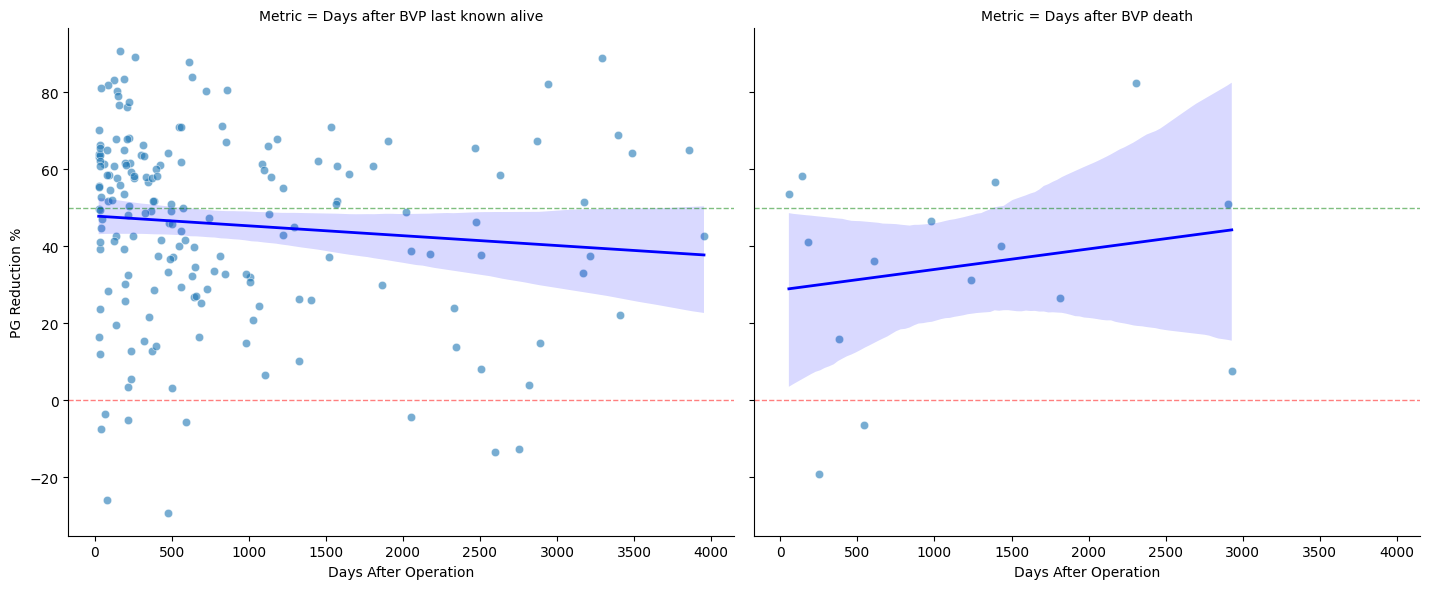

In [ ]:
# Reshape data for relplot
df_melted = df_unique.melt(
    id_vars=['Patient', 'PG_reduction_percent'],
    value_vars=['Days after BVP last known alive', 'Days after BVP death'],
    var_name='Metric', value_name='Days'
)

# Create relplot with two columns
g = sns.relplot(data=df_melted, x='Days', y='PG_reduction_percent',
                col='Metric', kind='scatter', alpha=0.6, height=6, aspect=1.2)

# Add regression lines and reference lines to both plots
for ax in g.axes.flat:
    # Get the data for this subplot
    metric = ax.get_title().split('=')[1].strip()
    subset = df_melted[df_melted['Metric'] == metric].dropna()

    # Add regression line
    sns.regplot(data=subset, x='Days', y='PG_reduction_percent',
                ax=ax, scatter=False, color='blue', line_kws={'linewidth': 2})

    # Add reference lines
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax.axhline(y=50, color='green', linestyle='--', linewidth=1, alpha=0.5)

g.set_axis_labels('Days After Operation', 'PG Reduction %')
plt.tight_layout()
plt.show()

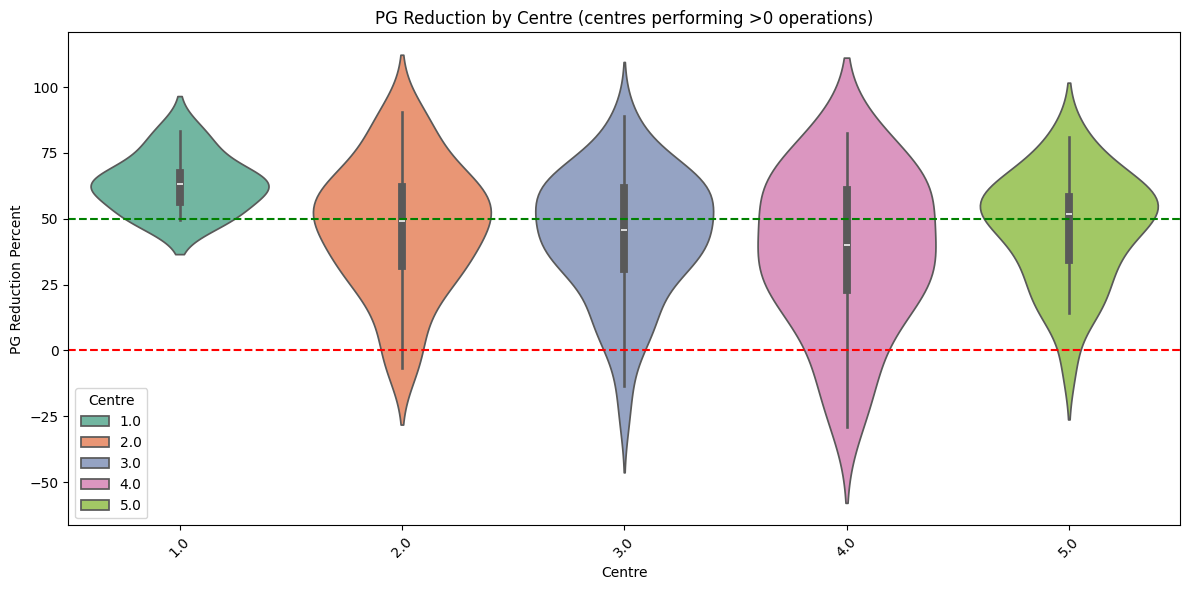

Included centres and their operation counts:
Centre
3.0    66
2.0    54
4.0    35
5.0    31
1.0    11
Name: count, dtype: int64


In [2368]:
MIN_CENTRE_COUNT = 0

value_counts = df_unique['Centre'].value_counts()

frequent_values = value_counts[value_counts > MIN_CENTRE_COUNT].index

df_filtered = df_unique[df_unique['Centre'].isin(frequent_values)]

plt.figure(figsize=(12, 6))
sns.violinplot(data=df_filtered, x='Centre', y='PG_reduction_percent', hue='Centre', palette="Set2")

plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5, label='0% (No change)')
plt.axhline(y=50, color='green', linestyle='--', linewidth=1.5, label='50% reduction')

plt.xlabel('Centre')
plt.ylabel('PG Reduction Percent')
plt.title(f'PG Reduction by Centre (centres performing >{MIN_CENTRE_COUNT} operations)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show counts for reference
print("Included centres and their operation counts:")
print(value_counts[value_counts > MIN_CENTRE_COUNT].sort_values(ascending=False))

In [2373]:
df.to_csv('data/data_cleaned.csv', index=False)